In [17]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import data_manager.utils as sbtu
import data_manager.scanner as scanner
import regime as sur
# import src.floor_ceiling_regime

In [18]:
_data_loader = sbtu.DataLoader.init_from_paths(r'..\data_args\other.json', r'..\data_args\base.json')
_strategy_path = _data_loader.file_path('strategy_lookup.pkl')
with open(_strategy_path, 'rb') as f:
    _strategy_lookup = pickle.load(f)

_entry_path = _data_loader.file_path('entry_table_15m.pkl')
with open(_entry_path, 'rb') as f:
    _entry_table = pickle.load(f)

_peak_path = _data_loader.file_path('peak_table_15m.pkl')
with open(_peak_path, 'rb') as f:
    _peak_table = pickle.load(f)

_bench_str = 'SPY'
_interval = '15m'
_price_data = pd.read_csv(_data_loader.history_path(_bench_str, _interval), index_col=0, header=[0,1]).astype('float64')
_bench = pd.read_csv(_data_loader.bench_path(_bench_str, _interval), index_col=0).astype('float64')
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_strategy_overview = pd.read_csv(_data_loader.file_path('stat_overview_15m.csv'))

_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()

<AxesSubplot:>

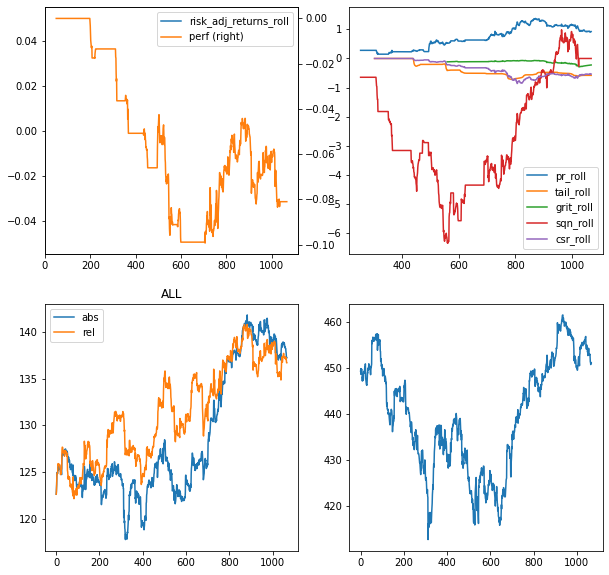

In [79]:
symbol = 'ALL'
_strat_data = _strategy_lookup[symbol]
_stats = _strategy_lookup[symbol].stat_historical
_, axs = plt.subplots(2, 2)
_stats[['risk_adj_returns_roll', 'perf']].plot(secondary_y=['perf'], ax=axs[0, 0], figsize=[10,10])
plot_copy = _stats[['pr_roll', 'tail_roll', 'grit_roll', 'sqn_roll', 'csr_roll']]
plot_copy.plot(ax=axs[0, 1])

def get_abs_rel(_s):
    sd = _price_data_by_symbol.data[_s]
    rel = sur.simple_relative(sd, _bench.close).close
    return pd.DataFrame(
        data={
            'abs': sd.close,
            'rel': rel
        }
    )

_symbol_data = _price_data_by_symbol.data[symbol]
get_abs_rel(symbol).plot(title=symbol, ax=axs[1, 0])
_bench.close.plot(ax=axs[1, 1])

<AxesSubplot:xlabel='entry'>

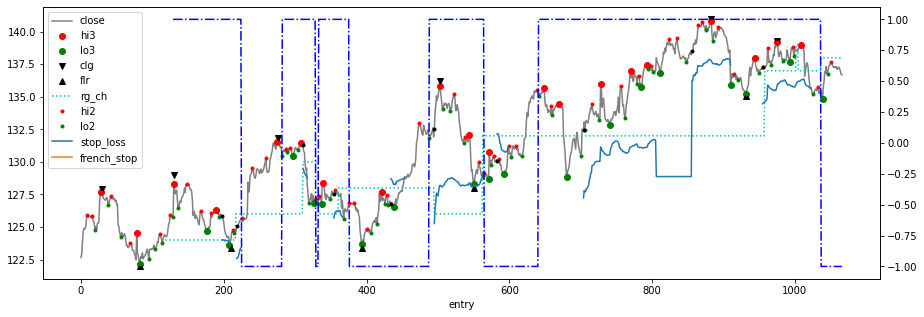

In [80]:
epd = _strategy_lookup[symbol].enhanced_price_data.copy()
epd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price
_sl = _strategy_lookup[symbol].stop_loss_series
_sl = _sl.loc[~_sl.index.duplicated(keep='first')]
epd['stop_loss'] = _sl
# epd['base_close'] = _symbol_data.close
scanner.enhanced_price_data_plot(epd)
_en_cpy = _entry_table.loc[_entry_table.symbol == symbol].copy()
_en_cpy.index = _en_cpy.entry
_en_cpy.en_px.plot(style='k.')

In [81]:

_pt = _strategy_lookup[symbol].peak_table.copy()
# _pt = pda.PeakTable(_pt)
# _pt = _pt.unpivot(_symbol_data.index)
# _pt = _pt.loc[~_pt.index.duplicated(keep='first')]
def filter_duplicates(_sw):
    return _sw.loc[~_sw.index.duplicated(keep='first')]

_shi_px = _pt.loc[(_pt.type == -1)].set_index('end')
_shi_1 = _shi_px.loc[(_shi_px.lvl == 1)]
_shi_1 = filter_duplicates(_shi_1)
_shi_2 = _shi_px.loc[(_shi_px.lvl == 2)]
_shi_2 = filter_duplicates(_shi_2)
_shi_3 = _shi_px.loc[(_shi_px.lvl == 3)]
_shi_3 = filter_duplicates(_shi_3)

_slo_px = _pt.loc[(_pt.type == 1)].set_index('end')
_slo_1 = _slo_px.loc[(_slo_px.lvl == 1)]
_slo_1 = filter_duplicates(_slo_1)
_slo_2 = _slo_px.loc[(_slo_px.lvl == 2)]
_slo_2 = filter_duplicates(_slo_2)
_slo_3 = _slo_px.loc[(_slo_px.lvl == 3)]
_slo_3 = filter_duplicates(_slo_3)

epd['hi1_lag'] = _shi_1.en_px
epd['hi2_lag'] = _shi_2.en_px
epd['hi3_lag'] = _shi_3.en_px
epd['lo1_lag'] = _slo_1.en_px
epd['lo2_lag'] = _slo_2.en_px
epd['lo3_lag'] = _slo_3.en_px

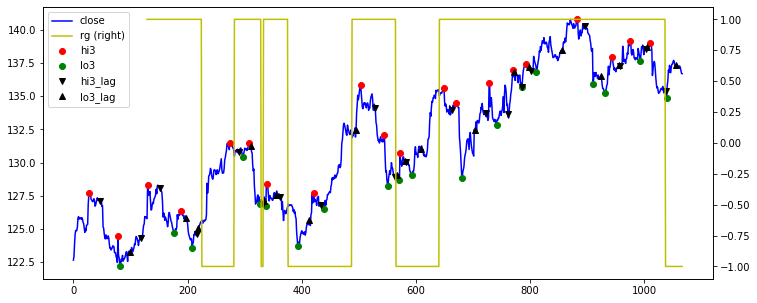

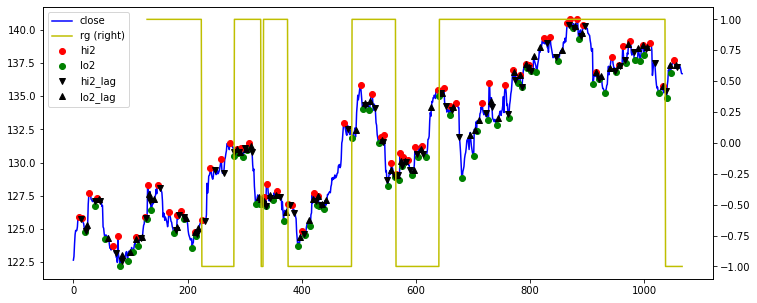

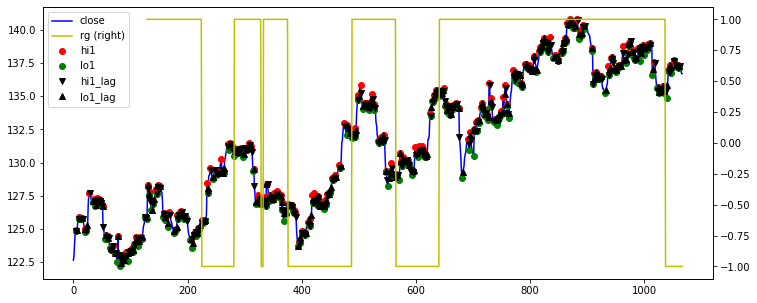

In [82]:


_epd_plt = epd[['close', 'hi2', 'lo2', 'hi3', 'lo3', 'rg']]

def plot(lvl):
    epd[[
        'close', 'rg',
        f'hi{lvl}', f'lo{lvl}',
        f'hi{lvl}_lag', f'lo{lvl}_lag',
    ]].plot(style=['b', 'y', 'ro', 'go', 'kv', 'k^'], figsize=[12, 5], secondary_y='rg')

plot(3)
plot(2)
plot(1)

<AxesSubplot:title={'center':'lvl3 lag'}, ylabel='Frequency'>

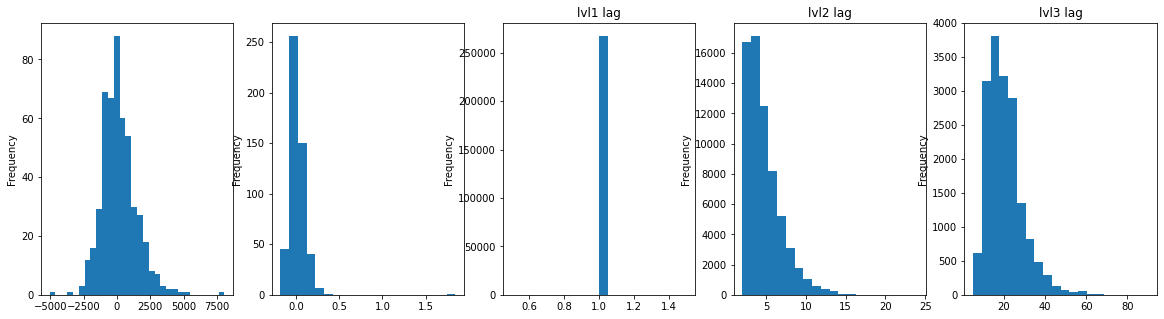

In [83]:
_, axs = plt.subplots(1, 5)
_strategy_overview.weight_total.plot.hist(bins=30, ax=axs[0], figsize=(20, 5))
_strategy_overview.perf.plot.hist(bins=20, ax=axs[1])

_peak_table['peak_lag'] = _peak_table.end - _peak_table.start
partial_exit_lag = _entry_table.partial_exit_date - _entry_table.entry
_peak_table.loc[_peak_table.lvl == 1, 'peak_lag'].plot.hist(bins=20, ax=axs[2], title='lvl1 lag')
_peak_table.loc[_peak_table.lvl == 2, 'peak_lag'].plot.hist(bins=20, ax=axs[3], title='lvl2 lag')
_peak_table.loc[_peak_table.lvl == 3, 'peak_lag'].plot.hist(bins=20, ax=axs[4], title='lvl3 lag')

In [84]:
_prev_exits = _entry_table.loc[
    (_entry_table.exit_signal_date != _symbol_data.index[-1])
].copy()
_prev_exits['sig_len'] = (_prev_exits.exit_signal_date - _prev_exits.entry)
_prev_exits['partial_sig_len'] = (_prev_exits.partial_exit_date - _prev_exits.entry)

In [85]:
sw = _peak_table.loc[(_peak_table.lvl == 2)].copy()
sw['sw_px_gap'] = (sw.en_px.shift(1) - sw.en_px) * sw.type
sw.loc[sw.symbol != sw.symbol.shift(1), 'sw_px_gap'] = np.nan
c = sw.sw_px_gap.loc[sw.sw_px_gap < 0].count()
win_rate = c / len(sw.loc[sw.sw_px_gap.notna()])
avg_win = sw.sw_px_gap.loc[sw.sw_px_gap < 0].sum() / len(sw.loc[sw.sw_px_gap.notna()]) * -1
avg_loss = sw.sw_px_gap.loc[sw.sw_px_gap > 0].sum() / len(sw.loc[sw.sw_px_gap.notna()])
win_rate * avg_win - (1-win_rate) * avg_loss

# lim = 2.5
# sw.sw_px_gap.loc[(sw.sw_px_gap < lim) & (sw.sw_px_gap > -lim)].plot.hist(bins=20)

0.34366787624400497

0.39572192513368987

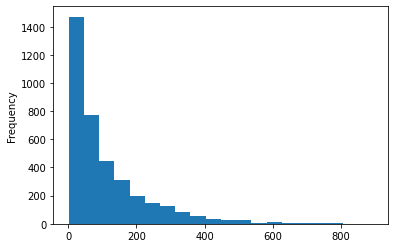

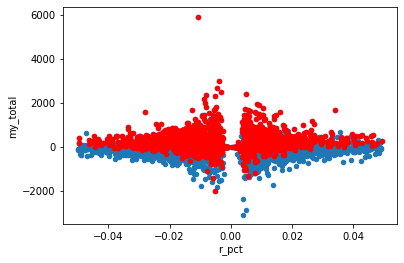

In [86]:
_entry_table['sig_len'] = (_entry_table.exit_signal_date - _entry_table.entry)
_entry_table['sig_len'].plot.hist(bins=20)

ax = _entry_table.plot.scatter(x='r_pct', y='my_total')
_entries_partial_exit = _entry_table.loc[_entry_table.partial_exit_date.notna()].copy()

_entries_partial_exit.plot.scatter(x='r_pct', y='my_total', color='r', ax=ax)

len(_entries_partial_exit) / len(_entry_table)


In [87]:
_entry_table.loc[abs(_entry_table.r_pct) > 0.2]

,entry,en_px,dir,trail_stop,fixed_stop,fixed_stop_price,r_pct,target_price,partial_exit_date,rg_id,...,shares,partial_profit,rem_profit,partial_total,no_partial_total,my_total,total,sig_len,entry_lag,entry_v


<AxesSubplot:ylabel='Frequency'>

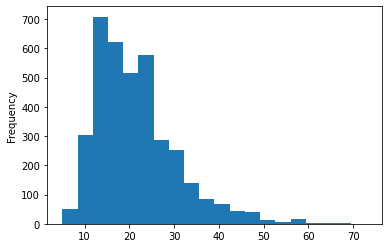

In [88]:
_entry_table['entry_lag'] = (_entry_table.entry - _entry_table.trail_stop)
_entry_table['entry_v'] = _entry_table.r_pct / _entry_table.entry_lag
# _entry_table.entry_lag.plot.hist(bins=20)
_entry_table['entry_v'] = abs(_entry_table.entry_v)
_entry_table.entry_lag.plot.hist(bins=20)

<AxesSubplot:xlabel='entry_v', ylabel='sig_len'>

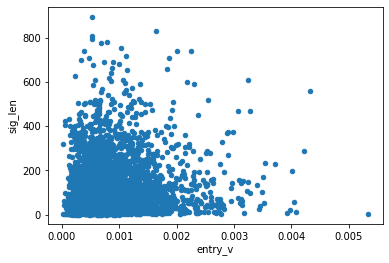

In [89]:
_entry_table.plot.scatter(x='entry_v', y='sig_len')

In [90]:
ax = _entry_table.loc[_entry_table.pct_break > 0].plot.scatter(x='pct_break', y='my_total')
_entries_partial_exit.loc[_entries_partial_exit.pct_break > 0].plot.scatter(x='pct_break', y='my_total', color='r', ax=ax)

AttributeError: 'DataFrame' object has no attribute 'pct_break'

In [ ]:
ax = _entry_table.loc[
    (_entry_table.vlty_break > 0) &
    (_entry_table.vlty_break < 30)
].plot.scatter(x='vlty_break', y='my_total')
_entries_partial_exit.loc[
    (_entries_partial_exit.vlty_break > 0) &
    (_entries_partial_exit.vlty_break < 30)
].plot.scatter(x='vlty_break', y='my_total', color='r', ax=ax)

_entry_table.loc[
    (_entry_table.vlty_break > 0) &
    (_entry_table.vlty_break < 15),
    'my_total'
].sum()

In [ ]:
ax = _entry_table.loc[
    (_entry_table.vlty_break > 0) &
    (_entry_table.vlty_break < 30)
].plot.scatter(x='vlty_break', y='sig_len')
_entries_partial_exit.loc[
    (_entries_partial_exit.vlty_break > 0) &
    (_entries_partial_exit.vlty_break < 30)
].plot.scatter(x='vlty_break', y='sig_len', color='r', ax=ax)